# Goal

Analyse main metrics by subject / committees / sponsor party and the votes adjacency matrics.


## Main Takeaways

### Subject
- The top subjects are: economics, army, taxes, health and transportation
- Republicans usually says more "no" than democrats except for energy and crime
- For each subject, adjacencies matrices change a lot from congress to congress
- In the last congress, taxes generated a lot of division between the parties but army is a subject that they agree on


### Committee
- Republicans usually says more "no" than democrats except for senate budget and senate security committees
- Nowadays, house appropriations keeps them really together but houseways and means and senate budget generated a lot of division
> Committee is hard to analyse over congress because I seems that they change

### Sponsor Party
- Laws sponsored by Democrats generated more connected components in the graph
- Republicans usually says more "no" than democrats even when the law is proposed by them
- In the begin, initiatives proposed by democrats were well accepted by republicans but it changed in congress 109



> There are subject, committee and sponsor party just for half of the data

In [1]:
import os
import pandas as pd
import numpy as np

import pickle
import networkx as nx

import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
ALL_LAWS_PATH = '../data/all-votes/laws_20years.csv'
ALL_ADJACENCY_PATH = '../data/all-votes/all_adjacency.pickle'
ALL_SUBJECT_PATH = '../data/all-votes/bills_20years.csv'
ALL_ADJACENCY_METRIS_PATH = '../data/all-votes/all_adjacency_metric.csv'
pal = {'republican': '#ff0000', 'democrats': '#0000ff'}
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=2, color_codes=True, rc=None)

In [3]:
all_laws = pd.read_csv(ALL_LAWS_PATH)
all_bills = pd.read_csv(ALL_SUBJECT_PATH)
all_adjacency_metrics = pd.read_csv(ALL_ADJACENCY_METRIS_PATH)
all_laws['law_id'] = all_laws['vote_uri'].apply(lambda x: '_'.join(x.split('/')[4:]).split('.')[0])
all_laws = all_laws.merge(all_bills, on='law_id', how='left')
all_laws = all_adjacency_metrics.merge(all_bills, on='law_id', how='left')

LOOKUP_RESULT = {
    'Agreed to': 'passed', 'Rejected': 'rejected', 'Nomination Confirmed': 'passed',
    'Cloture Motion Agreed to': 'passed', 'Amendment Rejected': 'rejected', 'Confirmed': 'passed',
    'Passed': 'passed', 'Amendment Agreed to': 'passed', 'Motion Rejected': 'rejected',
    'Motion Agreed to': 'passed', 'Bill Passed': 'passed', 'Motion to Table Agreed to': 'passed',
    'Cloture Motion Rejected': 'rejected', 'Motion to Proceed Agreed to': 'passed',
    'Cloture on the Motion to Proceed Agreed to': 'passed', 'Cloture on the Motion to Proceed Rejected': 'rejected'
}
all_laws['result_ok'] = all_laws.result.apply(lambda x: LOOKUP_RESULT.get(x, 'undefinied'))

with open(ALL_ADJACENCY_PATH, 'rb') as handle:
    adjacencies = pickle.load(handle)
    
print(all_laws.shape)
print(len(adjacencies))

(6834, 33)
6834


In [19]:
def get_metrics(data, by):
    m = data.copy()
    
    m[by] = m[by].str.lower().replace(np.nan, 'none', regex=True)
    m['%_republican_yes'] = m['republican_yes'] / (m['republican_yes'] + m['republican_no'])
    m['%_democrats_yes'] = m['democrats_yes'] / (m['democrats_yes'] + m['democrats_no'])
    
    counts = pd.DataFrame(m.groupby(by).size()).reset_index().rename(columns={0: 'count'})
    yes = pd.DataFrame(m.groupby(by).mean()[['%_republican_yes', '%_democrats_yes']]).reset_index()
    yes['yes_delta_parties'] = yes['%_republican_yes'] - yes['%_democrats_yes']
    status = pd.DataFrame(m.groupby([by, 'result_ok']).size().unstack()).fillna(0)
    status = pd.DataFrame(status['passed'] / (status['passed'] + status['rejected'])).reset_index().rename(columns={0: '%_passed'})
    adjacency = pd.DataFrame(m.groupby(by).mean()[['connected_components', 'density', 'L']]).reset_index()
    
    return (counts
            .merge(yes)
            .merge(status)
            .merge(adjacency)
            .set_index(by)
            .sort_values('count', ascending=False)
            .applymap(lambda x: round(x, 3)))

## General metrics congress by subject, sponsor committee and sponsor party

In [20]:
all_laws['primary_subject'] = all_laws['primary_subject'].str.lower()
count_by_subject = all_laws.groupby(['congress', 'primary_subject']).size().reset_index().rename(columns={0: 'count_by_congress'})
total_count = all_laws.groupby('congress').size().reset_index().rename(columns={0: 'count'})
d = count_by_subject.merge(total_count).sort_values(['congress', 'count_by_congress'], ascending=False)
tops = ['economics and public finance', 
        'armed forces and national security', 
        'taxation', 'health', 'energy', 
        'transportation and public works', 
        'finance and financial sector', 'imigration']
d = d[d['primary_subject'].apply(lambda x: True if x in tops else False)]

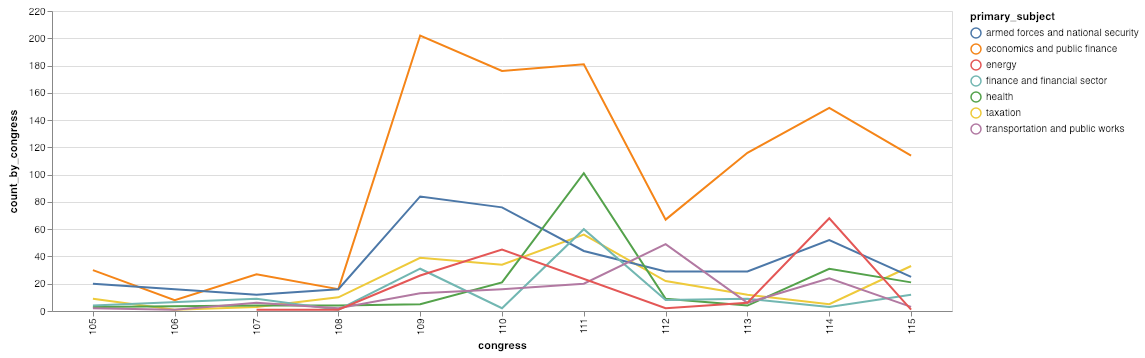

In [21]:
alt.Chart(d, width=900, height=300).mark_line().encode(
    x='congress:O',
    y='count_by_congress',
    color='primary_subject',
)

In [25]:
all_laws.columns

Index(['L', 'connected_components', 'degree_centality', 'density',
       'eigenvalues', 'shape', 'law_id', 'bill_api_uri', 'congress', 'date',
       'democrats_no', 'democrats_yes', 'independent_no', 'independent_yes',
       'month', 'republican_no', 'republican_yes', 'result', 'total_no',
       'total_not_voting', 'total_yes', 'vote_type', 'vote_uri', 'year', 'q',
       'quarter', 'Unnamed: 0', 'committees', 'primary_subject', 'short_title',
       'sponsor_id', 'sponsor_party', 'result_ok', 'sponser_committees'],
      dtype='object')

In [75]:
print('Republican sponsor')
pd.DataFrame(all_laws[all_laws['sponsor_party'] == 'R']['primary_subject'].value_counts()).iloc[0:10]

Republican sponsor


primary_subject
economics and public finance                    625
armed forces and national security              221
taxation                                        115
energy                                          100
health                                           67
international affairs                            64
finance and financial sector                     62
transportation and public works                  61
crime and law enforcement                        60
emergency management                             55

In [76]:
print('Republican sponsor')
pd.DataFrame(all_laws[all_laws['sponsor_party'] == 'R']['primary_subject'].value_counts()).iloc[0:10]

Republican sponsor


primary_subject
economics and public finance                    625
armed forces and national security              221
taxation                                        115
energy                                          100
health                                           67
international affairs                            64
finance and financial sector                     62
transportation and public works                  61
crime and law enforcement                        60
emergency management                             55

## General metrics by subject

In [22]:
get_metrics(all_laws, 'primary_subject').iloc[0:15]

count  %_republican_yes  %_democrats_yes  \
primary_subject                                                                
none                                 3389             0.649            0.682   
economics and public finance         1086             0.597            0.642   
armed forces and national security    387             0.695            0.761   
taxation                              224             0.504            0.654   
health                                203             0.506            0.651   
energy                                150             0.615            0.573   
transportation and public works       142             0.652            0.697   
finance and financial sector          139             0.557            0.692   
agriculture and food                  122             0.555            0.588   
immigration                           115             0.558            0.628   
crime and law enforcement             105             0.785            0.669   
international affairs                  95             0.747            0.773   
emergency management                   94             0.567            0.703   
government operations and politics     78             0.526            0.653   
education                              74             0.585            0.698   

                                    yes_delta_parties  %_passed  \
primary_subject                                                   
none                                           -0.033     0.717   
economics and public finance                   -0.045     0.562   
armed forces and national security             -0.066     0.685   
taxation                                       -0.150     0.419   
health                                         -0.146     0.566   
energy                                          0.042     0.479   
transportation and public works                -0.046     0.647   
finance and financial sector                   -0.135     0.541   
agriculture and food                           -0.032     0.509   
immigration                                    -0.069     0.626   
crime and law enforcement                       0.116     0.600   
international affairs                          -0.026     0.738   
emergency management                           -0.136     0.576   
government operations and politics             -0.127     0.436   
education                                      -0.112     0.486   

                                    connected_components  density         L  
primary_subject                                                              
none                                               7.776    0.587  6129.867  
economics and public finance                       8.088    0.551  5830.681  
armed forces and national security                 7.966    0.635  6633.003  
taxation                                           9.022    0.508  5459.839  
health                                            10.064    0.513  5702.158  
energy                                             7.933    0.523  5287.707  
transportation and public works                    8.951    0.588  6156.944  
finance and financial sector                      10.338    0.524  5812.978  
agriculture and food                               8.648    0.524  5539.590  
immigration                                        7.261    0.522  5385.391  
crime and law enforcement                          7.867    0.634  6588.457  
international affairs                              7.337    0.701  7223.011  
emergency management                               6.862    0.580  5907.787  
government operations and politics                 6.551    0.564  5852.385  
education                                          7.757    0.554  5710.216

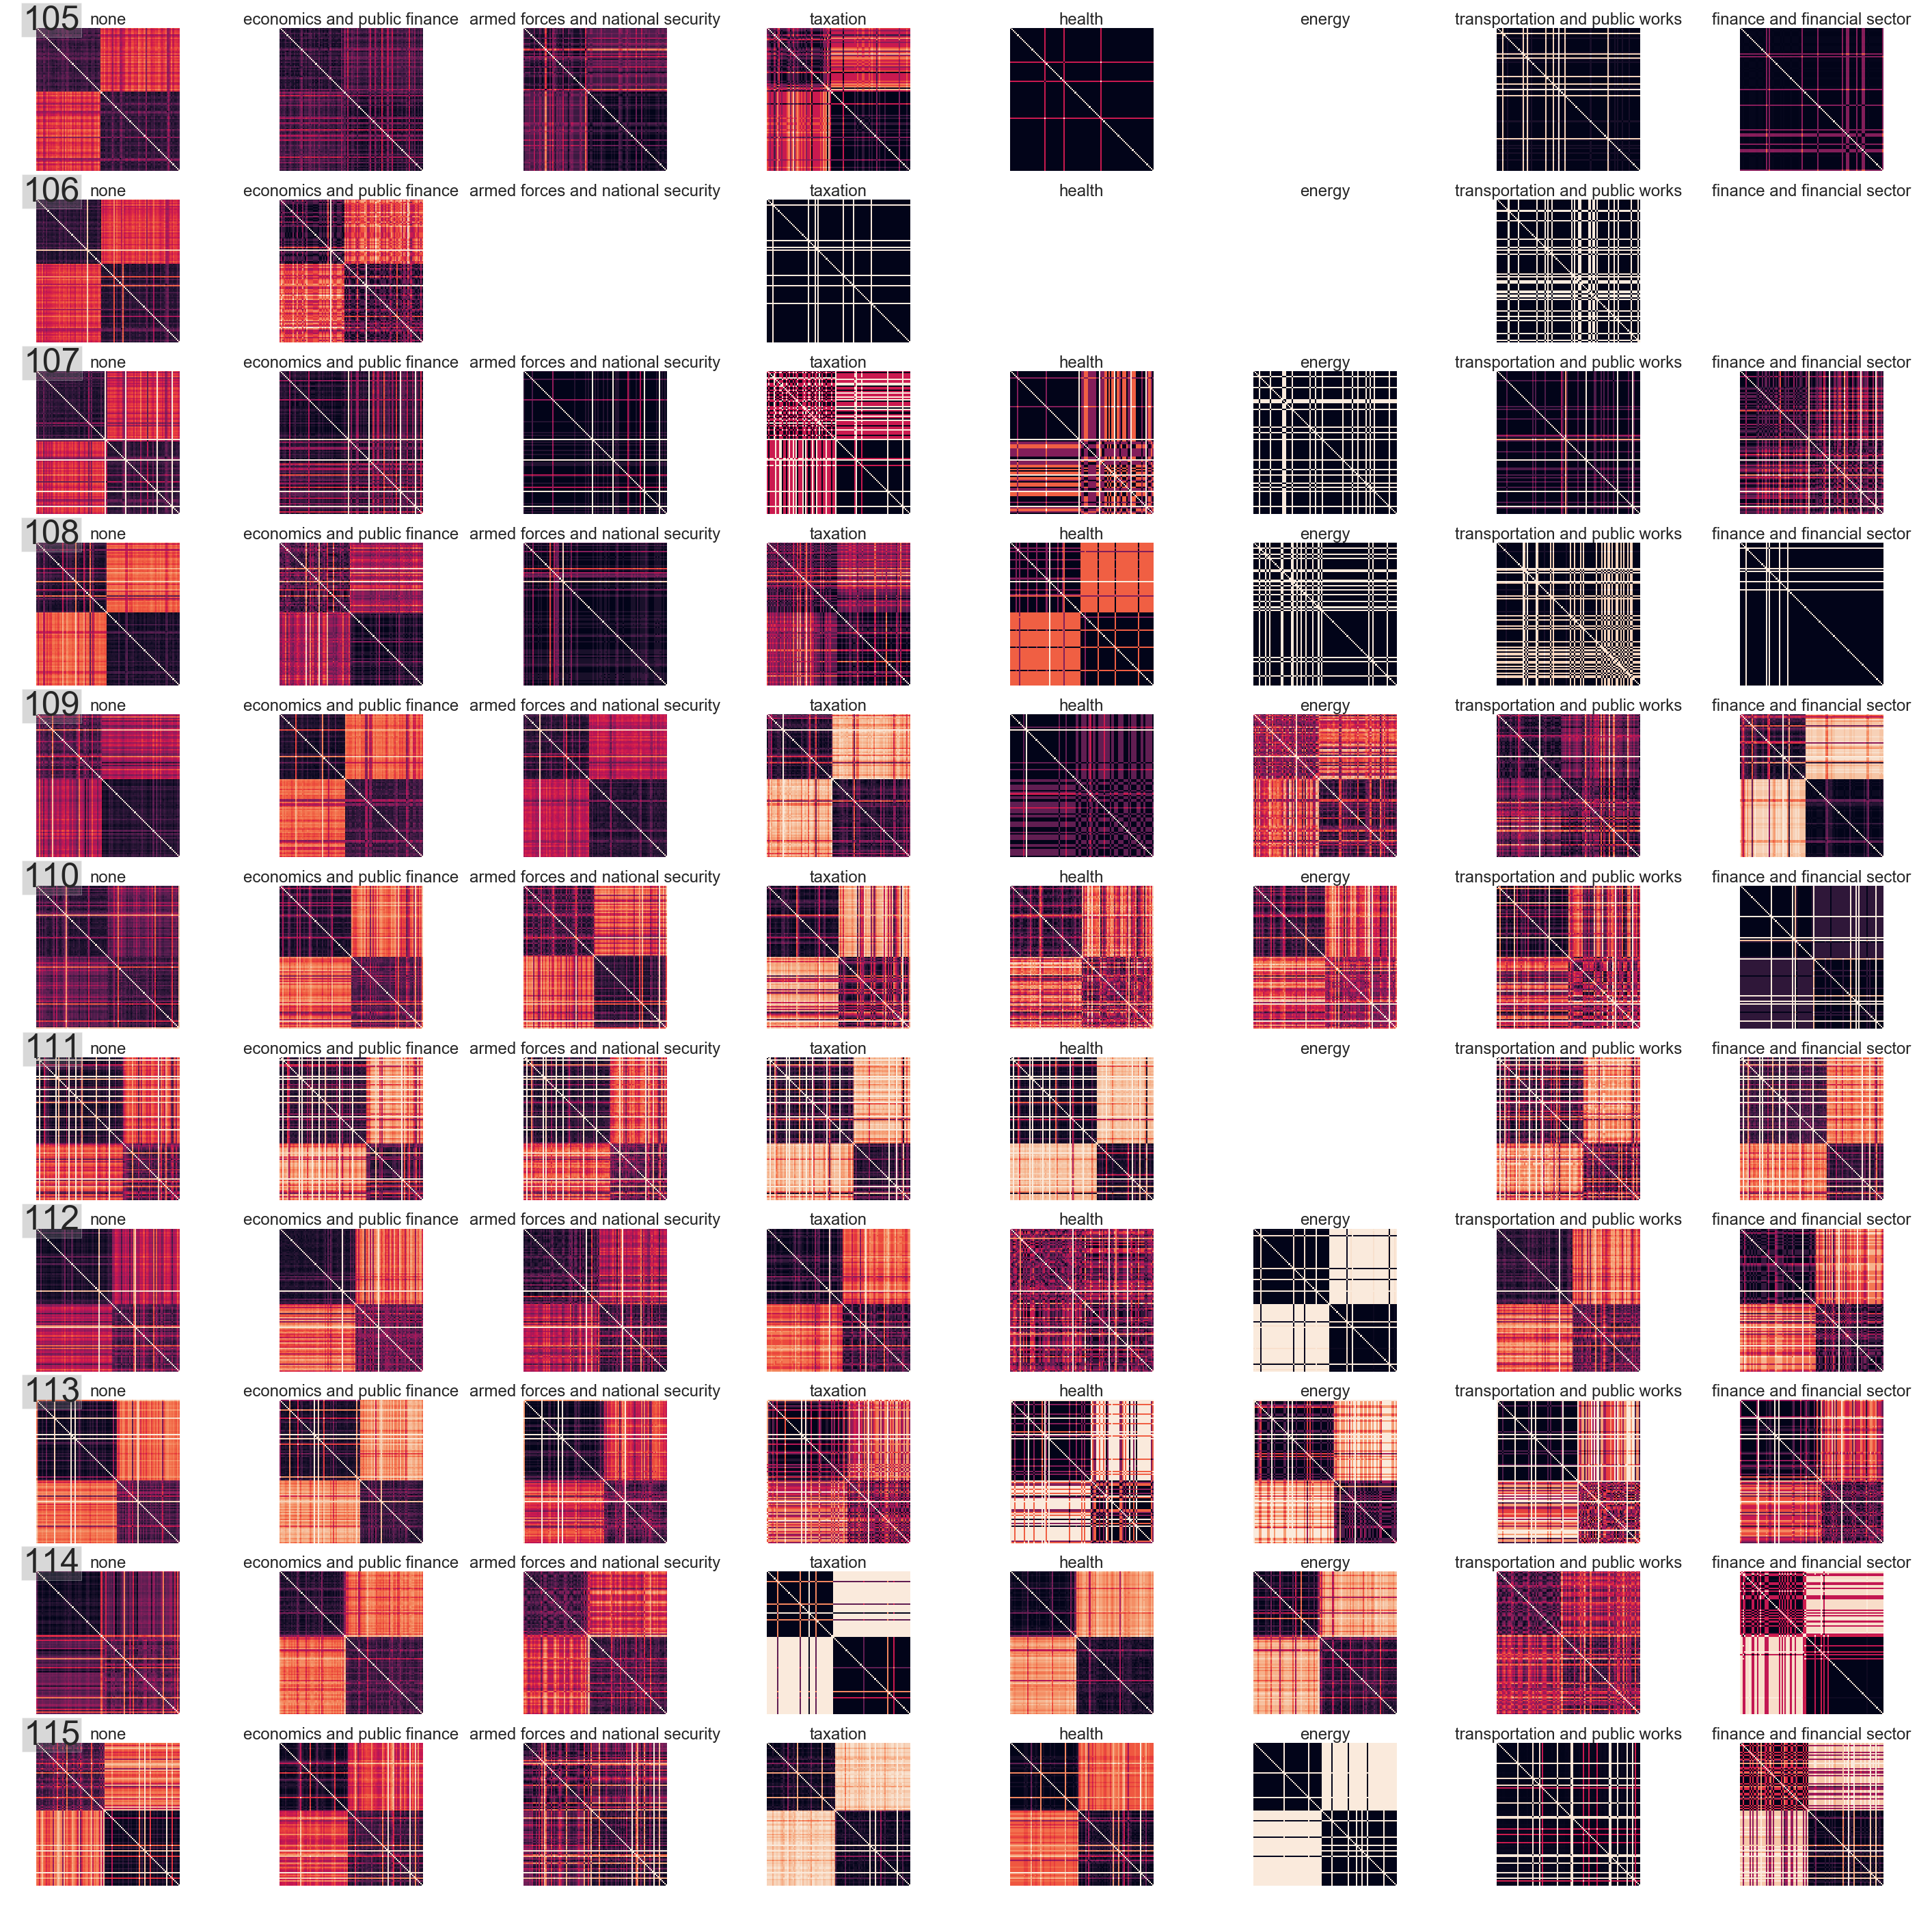

In [23]:
subject = list(get_metrics(all_laws, 'primary_subject').iloc[0:8].index)
all_laws['primary_subject'] = all_laws['primary_subject'].apply(lambda x: x if pd.notnull(x) else 'none')
congress = all_laws['congress'].unique()

f, ax = plt.subplots(len(congress), len(subject), figsize=(50, 50))

for i, c in enumerate(congress):
    ax[i, 0].text(-10, 0, c, fontsize=50, bbox={'facecolor': 'grey', 'alpha':0.3, 'pad': 2})
    ax[i, 0].axis('off')
    
    for j, p in enumerate(subject):
        laws = list(all_laws[(all_laws.primary_subject == p) & (all_laws.congress == c)]['law_id'])
        n = len(laws)
        if n > 0:
            sum_adjacencies = adjacencies[laws[0]]
            for l in laws[1:]:
                sum_adjacencies += adjacencies[l]

            sum_adjacencies /= n
            sum_adjacencies = 1 - sum_adjacencies # xunxo to get right color pattern

            ax[i, j].imshow(sum_adjacencies)
            ax[i, j].axis('off')
            ax[i, j].set_title(p)
        else:
            ax[i, j].axis('off')
            ax[i, j].set_title(p)

## General metric by committees

In [9]:
d = (all_laws['committees'].str.lower()
     .str.replace(' ', '') # Some of them had difference in the spaces, so annoying! 
     .str.replace('committee', '')
     .str.split(';', expand=True))
d['law_id'] = all_laws['law_id']
d = d.set_index('law_id')
d = pd.DataFrame(d.stack())
d = d.reset_index().merge(all_laws).rename(columns={0: 'unique_sponsor_committee'})

get_metrics(d, 'unique_sponsor_committee')

count  %_republican_yes  \
unique_sponsor_committee                                                
houseappropriations                             643             0.647   
housewaysandmeans                               436             0.590   
senatebudget                                    399             0.578   
senateappropriations                            399             0.605   
housebudget                                     326             0.535   
housetransportationandinfrastructure            209             0.645   
senatejudiciary                                 171             0.562   
housejudiciary                                  161             0.613   
houseenergyandcommerce                          155             0.561   
housefinancialservices                          128             0.493   
senatearmedservices                             123             0.688   
househomelandsecurity                           109             0.590   
houseeducationandlabor                          106             0.580   
housearmedservices                               98             0.702   
housenaturalresources                            94             0.627   
houseagriculture                                 92             0.602   
senatehealth,education,labor,andpensions         86             0.696   
senatebanking,housing,andurbanaffairs            83             0.672   
senatefinance                                    83             0.483   
senatehomelandsecurityandgovernmentalaffairs     74             0.618   
senateagriculture,nutrition,andforestry          63             0.556   
senateforeignrelations                           59             0.663   
senateenvironmentandpublicworks                  59             0.670   
houseoversightandgovernmentreform                57             0.513   
houseeducationandtheworkforce                    53             0.766   
houseforeignaffairs                              51             0.632   
houserules                                       38             0.548   
houseintelligence(permanentselect)               35             0.736   
senatecommerce,science,andtransportation         33             0.761   
housescience                                     31             0.692   
houseresources                                   30             0.678   
housesmallbusiness                               28             0.595   
houseinternationalrelations                      26             0.931   
senateenergyandnaturalresources                  25             0.687   
housescienceandtechnology                        24             0.626   
senateintelligence(select)                       23             0.444   
senaterulesandadministration                     23             0.695   
senatesmallbusinessandentrepreneurship           15             0.517   
houseadministration                              14             0.600   
senateindianaffairs                              11             0.782   
senateintelligence                                9             0.365   
senateveterans'affairs                            8             0.860   
houseintelligence(permanent)                      7             0.634   
housecommerce                                     7             0.992   
housescience,space,andtechnology                  7             0.486   
househouseadministration                          6             0.152   
housegovernmentreformandoversight                 5             0.993   
senatelaborandhumanresources                      5             0.970   
housenationalsecurity                             4             0.982   
housebankingandfinancialservices                  4             0.972   
houseveterans'affairs                             3             0.925   
housegovernmentreform                             3             1.000   
househomelandsecurity(select)                     2             1.000   
jointthehelsinkicommission     

## Adjacency Matrices by committees

In [10]:
all_laws['sponser_committees'] = (all_laws['committees'].str.lower().str.replace(' ', '').str.replace('committee', ''))

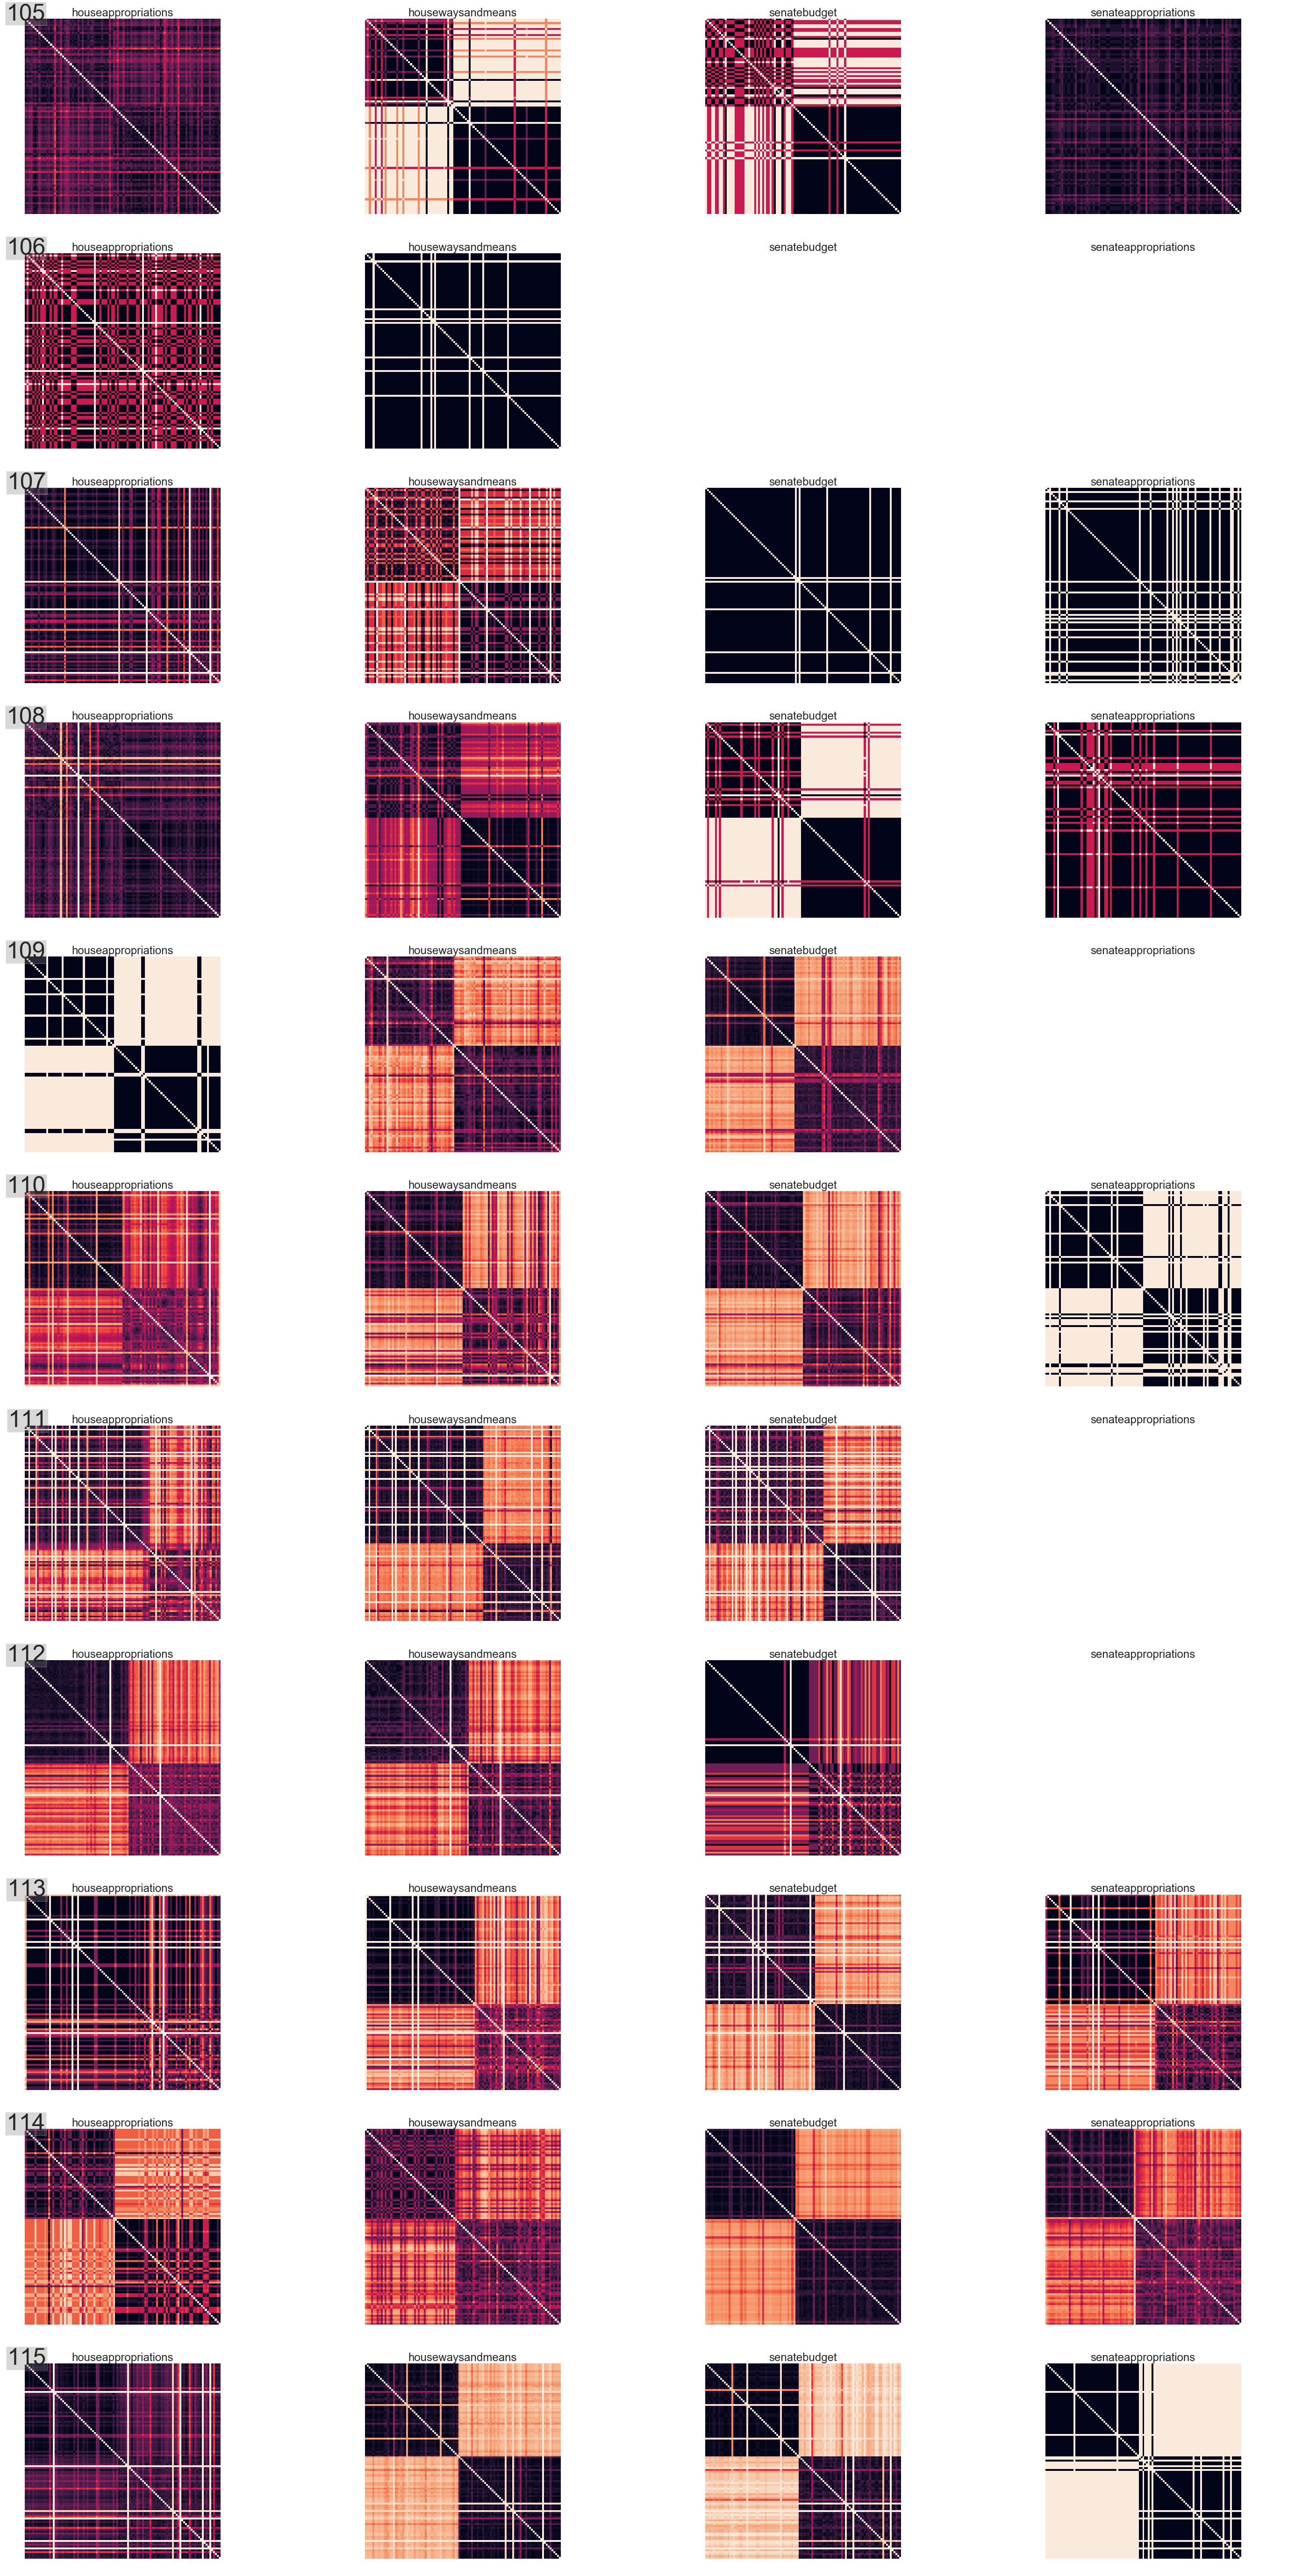

In [11]:
committees = ['houseappropriations', 'housewaysandmeans', 'senatebudget', 'senateappropriations']
congress = all_laws['congress'].unique()

f, ax = plt.subplots(len(congress), len(committees), figsize=(50, 100))

for i, c in enumerate(congress):
    ax[i, 0].text(-10, 0, c, fontsize=50, bbox={'facecolor': 'grey', 'alpha':0.3, 'pad': 2})
    ax[i, 0].axis('off')
    
    for j, p in enumerate(committees):
        laws = list(all_laws[(all_laws.sponser_committees.apply(lambda x: True if pd.notnull(x) and x in p else False)) & (all_laws.congress == c)]['law_id'])
        n = len(laws)
        if n > 0:
            sum_adjacencies = adjacencies[laws[0]]
            for l in laws[1:]:
                sum_adjacencies += adjacencies[l]

            sum_adjacencies /= n
            sum_adjacencies = 1 - sum_adjacencies # xunxo to get right color pattern

            ax[i, j].imshow(sum_adjacencies)
            ax[i, j].axis('off')
            ax[i, j].set_title(p)
        else:
            ax[i, j].axis('off')
            ax[i, j].set_title(p)

## General metrics by sponsor party

In [12]:
get_metrics(all_laws, 'sponsor_party')

count  %_republican_yes  %_democrats_yes  yes_delta_parties  \
sponsor_party                                                                
None            3321             0.649            0.686             -0.037   
r               1772             0.653            0.670             -0.017   
d               1687             0.579            0.658             -0.080   
i                 45             0.525            0.596             -0.070   
id                 9             0.471            0.573             -0.103   

               %_passed  connected_components  density         L  
sponsor_party                                                     
None              0.724                 7.701    0.588  6139.014  
r                 0.601                 6.019    0.604  6171.406  
d                 0.558                10.936    0.527  5769.124  
i                 0.366                 6.800    0.543  5694.489  
id                0.625                13.333    0.481  5767.556

## Adjacency Matrices by sponsor party

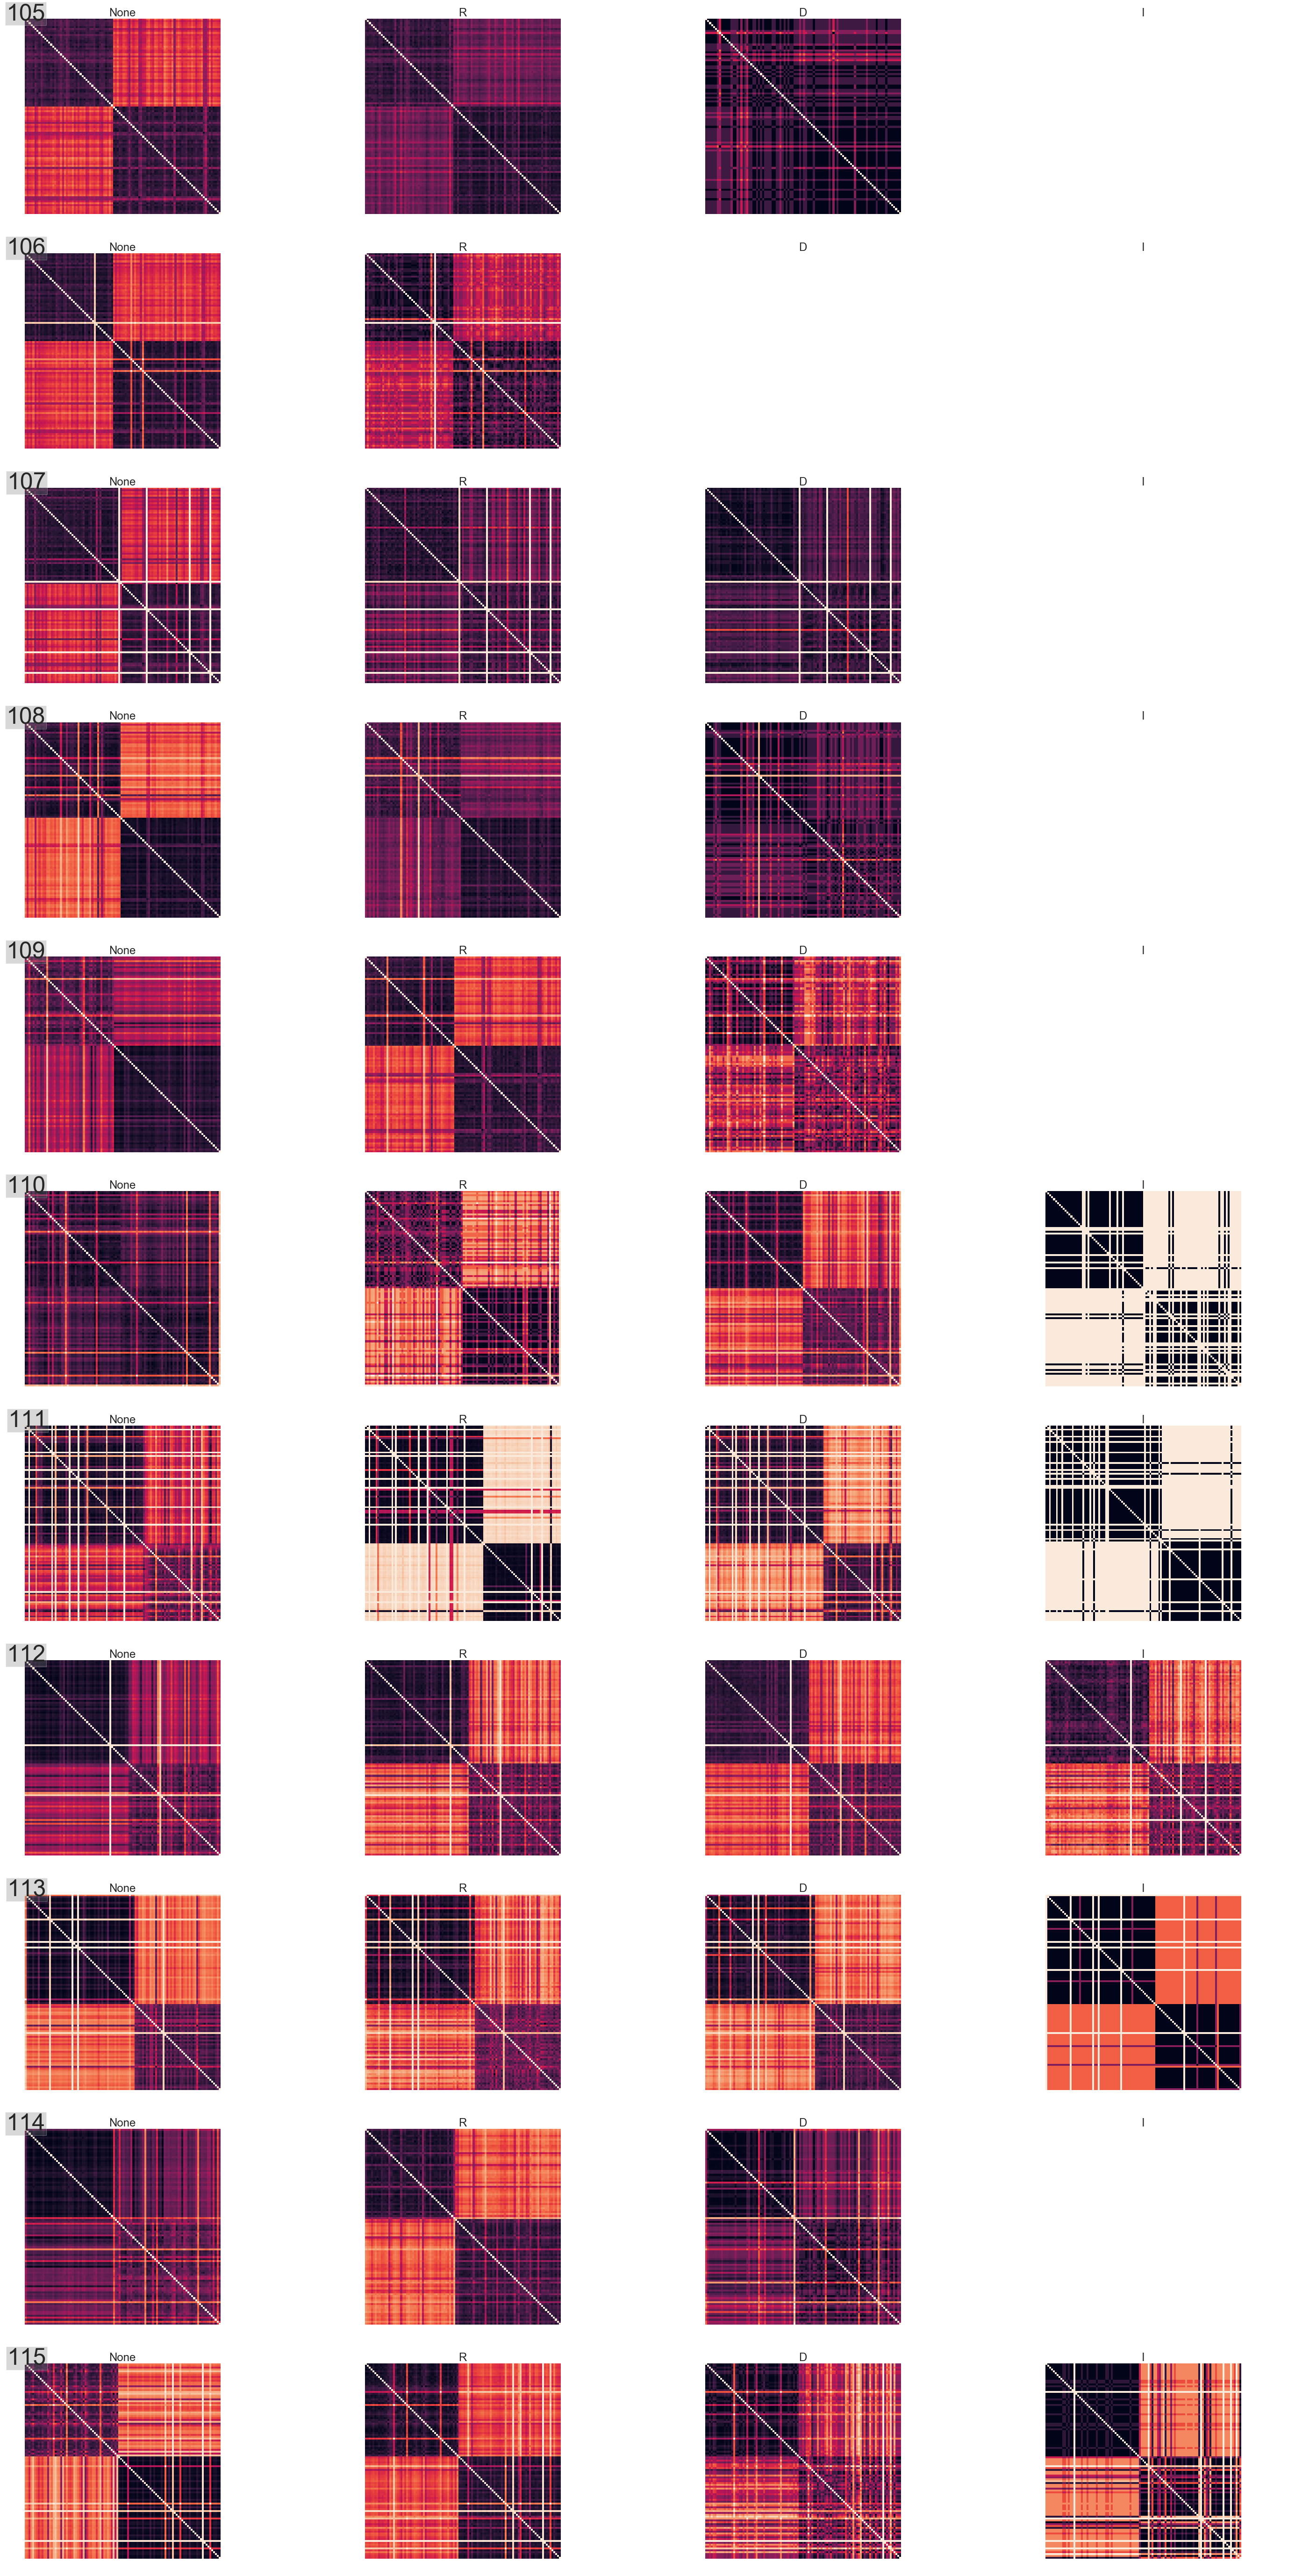

In [13]:
party = ['None', 'R', 'D', 'I']
congress = all_laws['congress'].unique()
all_laws['sponsor_party'] = all_laws['sponsor_party'].apply(lambda x: 'None' if pd.isnull(x) else x) 

f, ax = plt.subplots(len(congress), len(party), figsize=(50, 100))

for i, c in enumerate(congress):
    ax[i, 0].text(-10, 0, c, fontsize=50, bbox={'facecolor': 'grey', 'alpha':0.3, 'pad': 2})
    ax[i, 0].axis('off')
    
    for j, p in enumerate(party):
        laws = list(all_laws[(all_laws.sponsor_party == p) & (all_laws.congress == c)]['law_id'])
        n = len(laws)
        if n > 0:
            sum_adjacencies = adjacencies[laws[0]]
            for l in laws[1:]:
                sum_adjacencies += adjacencies[l]

            sum_adjacencies /= n
            sum_adjacencies = 1 - sum_adjacencies # xunxo to get right color pattern

            ax[i, j].imshow(sum_adjacencies)
            ax[i, j].axis('off')
            ax[i, j].set_title(p)
        else:
            ax[i, j].axis('off')
            ax[i, j].set_title(p)